<a href="https://colab.research.google.com/github/Mkenza/project_DL/blob/master/Labs/T4-MAKHLOUF-UNET_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation using UNET Autoencoder

In this lab, we will develop a deep learning  image segmentation using UNet autoencoder. Image Segmentation is a technique in digital image processing that describes the process of partitioning an image into sections. Often the goal is to identify and extract specific shapes of interest in an image.

## UNET Architecture

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

<img src="https://raw.githubusercontent.com/foobar167/articles/master/Machine_Learning/data/2019.04.26_u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.


In [1]:
# import these packages as follows.
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
import matplotlib.pyplot as plt 
%matplotlib inline 

**Download and Prepare the Data**

“images” folder contains 7390 jpg images of various pets and the “trimaps” folder that contains the segmentation masks corresponding to the pet images.

https://drive.google.com/file/d/1oVUG3TvQI3uxJxZs6OYn_wKbChuwiCdF/view?usp=sharing

In [2]:
# Monter votre Drive afin de pouvoir y'acceder 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/oxford_pets.zip"

with ZipFile(file_name, 'r') as zip1:
  zip1.extractall()
  print('Done')

Done


Prepare paths of input images and target segmentation masks

Next, we create a sorted list with all the image paths so that we can import the images and their corresponding segmentation masks in parallel.

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [5]:
# Prepare Sequence class to load & vectorize batches of data

from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

Let’s visualize a selected sample and its corresponding mask from the training data.

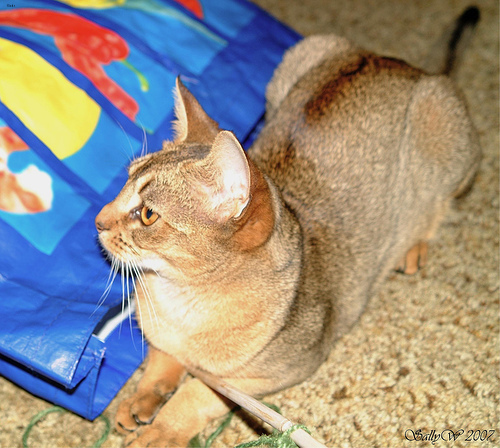

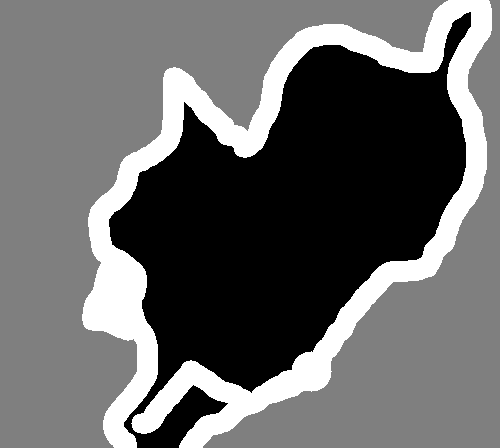

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

**Building a UNet** 

 There are always two convolutional layers with ReLU activation functions followed by a Max Pooling layer that reduces the vertical and horizontal image dimensions by half while expanding the third dimension.

In a UNet, we employ skip connections, which means that we want to preserve the feature map before pooling and pass it to the corresponding upsampling block. Accordingly, we save the feature map to a variable called skip connection, without the pooling applied to it.

The expansive part performs a series of upsampling operations that basically reverse the convolutions and reconstruct the original image. As input, we pass the output from the preceding layer and the skip connection from the corresponding downsampling block. The horizontal arrows in the diagram nicely illustrate how the skip connections travel. Lastly, we also pass the number of filters.

As input, we require the dimensions of the input image, along with the number of filters and the number of classes we want to distinguish between.

In [7]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Set train / validation split

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

Train the model

In [9]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 64s 251ms/step - loss: 0.9224 - val_loss: 2.4152
Epoch 2/15
199/199 [==============================] - 54s 268ms/step - loss: 0.5051 - val_loss: 2.5871
Epoch 3/15
199/199 [==============================] - 52s 262ms/step - loss: 0.4331 - val_loss: 0.4767
Epoch 4/15
199/199 [==============================] - 53s 267ms/step - loss: 0.3879 - val_loss: 0.4175
Epoch 5/15
199/199 [==============================] - 53s 264ms/step - loss: 0.3531 - val_loss: 0.3900
Epoch 6/15
199/199 [==============================] - 52s 260ms/step - loss: 0.3229 - val_loss: 0.3901
Epoch 7/15
199/199 [==============================] - 51s 257ms/step - loss: 0.2972 - val_loss: 0.4741
Epoch 8/15
199/199 [==============================] - 55s 275ms/step - loss: 0.2749 - val_loss: 0.3849
Epoch 9/15
199/199 [==============================] - 52s 259ms/step - loss: 0.2570 - val_loss: 0.4256
Epoch 10/15
199/199 [==============================] - 51s 254ms/step - l

Visualize predictions

31/31 [==============================] - 5s 161ms/step


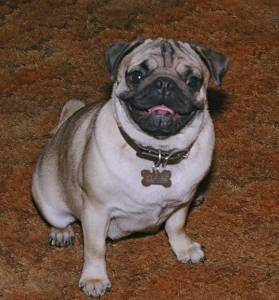

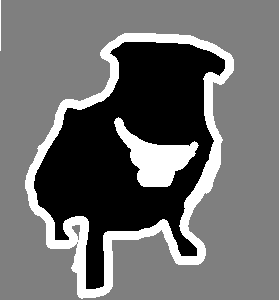

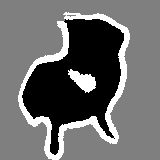

In [10]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

**Question:** Modify the UNET model in order to use a pretrained model like VGG16 or Resnet (to replace the original encoder block of the UNET model).

In [24]:
from tensorflow.keras import layers

from tensorflow.keras.applications import VGG16

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = vgg16.get_layer("block1_conv2").output 

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for block in ["block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]:
        x = vgg16.get_layer(block).output  
        print(f"shape of {block}: ", x.shape[3])
        # Project residual
        residual = layers.Conv2D(x.shape[3], 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [25]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

shape of block2_conv2:  128
shape of block3_conv3:  256
shape of block4_conv3:  512
shape of block5_conv3:  512
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 160, 160, 64  36928       ['block1_conv1[0

In [26]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("vgg16_oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 113s 529ms/step - loss: 1428674.1250 - val_loss: 16.8522
Epoch 2/15
199/199 [==============================] - 104s 523ms/step - loss: 52.7361 - val_loss: 2.8063
Epoch 3/15
199/199 [==============================] - 104s 522ms/step - loss: 14.1563 - val_loss: 1.1970
Epoch 4/15
199/199 [==============================] - 104s 520ms/step - loss: 1.4425 - val_loss: 0.8842
Epoch 5/15
199/199 [==============================] - 103s 518ms/step - loss: 0.6405 - val_loss: 1.0151
Epoch 6/15
199/199 [==============================] - 103s 519ms/step - loss: 0.4900 - val_loss: 1.0883
Epoch 7/15
199/199 [==============================] - 103s 519ms/step - loss: 0.4186 - val_loss: 1.0881
Epoch 8/15
199/199 [==============================] - 104s 522ms/step - loss: 0.3744 - val_loss: 0.9529
Epoch 9/15
199/199 [==============================] - 104s 520ms/step - loss: 0.3441 - val_loss: 1.0986
Epoch 10/15
199/199 [==============================] - 

31/31 [==============================] - 7s 216ms/step


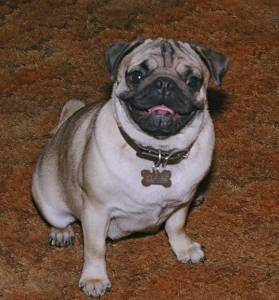

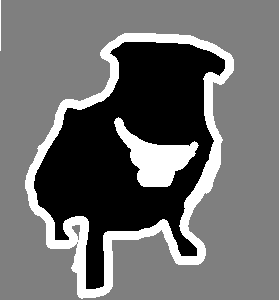

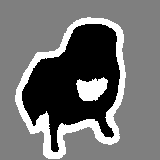

In [30]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

31/31 [==============================] - 6s 199ms/step


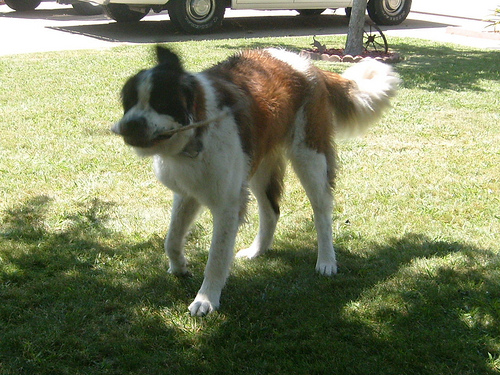

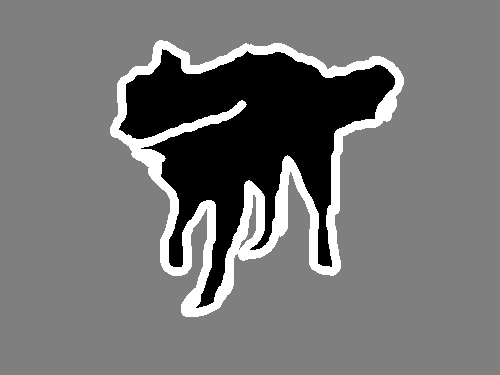

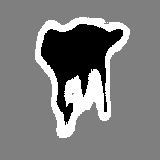

In [29]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #12
i = 12

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.